In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import random

In [2]:
def plot_data_examples(data, data2, name_img = None, source = None, num_examples=9):
    # Generate random indices for the examples you want to plot
    example_indices = [(random.randint(0, 39), random.randint(0, 19)) for _ in range(num_examples)]

    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    # Iterate through the selected examples and create subplots for each
    for i, (row_idx, col_idx) in enumerate(example_indices):
        # Extract the data for the current example
        example_data = data[:, row_idx, col_idx]

        # Calculate the standard deviation and plot it
        std_data = np.std(example_data)

        # Plot the data
        axes[i].plot(example_data, linestyle='-', linewidth=1, color='orange', label='With Noise')
        axes[i].plot(data2[:, row_idx, col_idx], linestyle='-', linewidth=1, color='g', label='No noise')
        axes[i].set_xlabel('v[Km/s]', fontsize=15)
        axes[i].set_ylabel(r'${\tau}$', fontsize=15)
        axes[i].axhline(0, color='k', linestyle='--', linewidth=2)
        axes[i].axhspan(- std_data, std_data, alpha=0.2, color='grey')
        axes[i].set_title(f'Example: ({row_idx}, {col_idx})')
        axes[i].grid(True)

    # Adjust layout
    plt.tight_layout()
    if name_img is not None:
        # Ensure the output directory exists
        output_dir = os.path.join('Images', source)
        os.makedirs(output_dir, exist_ok=True)

        # Save the figure
        output_path = os.path.join(output_dir, f'{name_img}.png')
        plt.savefig(output_path)

    # Show the figure
    plt.show()



# I/O

In [3]:
source_name = 'hydra'

In [4]:
fits_file_4k = f'Data_cubes/{source_name}/spectra_4k.fits'
hdulist_4k = fits.open(fits_file_4k)
data_4k = hdulist_4k[0].data

# Calculate the RMS for each spectrum
rms_values_4k = np.std(data_4k, axis = 0)
rms_flatten_4k = rms_values_4k.ravel()

In [5]:
fits_file_v2_1000 = f'Data_cubes/{source_name}/spectra_v2-1000.fits'
hdulist_v2_1000 = fits.open(fits_file_v2_1000)
data_v2_1000 = hdulist_v2_1000[0].data

# Calculate the RMS for each spectrum
rms_values_v2_1000 = np.std(data_v2_1000, axis = 0)
rms_flatten_v2_1000 = rms_values_v2_1000.ravel()

In [6]:
fits_file_v2_1500 = f'Data_cubes/{source_name}/spectra_v2-1500.fits'
hdulist_v2_1500 = fits.open(fits_file_v2_1500)
data_v2_1500 = hdulist_v2_1500[0].data

# Calculate the RMS for each spectrum
rms_values_v2_1500 = np.std(data_v2_1500, axis = 0)
rms_flatten_v2_1500 = rms_values_v2_1500.ravel()

In [7]:
data_flatten_4k = data_4k.ravel()
data_flatten_v2_1000 = data_v2_1000.ravel()
data_flatten_v2_1500 = data_v2_1500.ravel()

# Creation of synthetic data

### Explanation:



The relationship between the standard deviation $\sigma$ and the FWHM is:

$ \text{FWHM} = 2 \sqrt{2 \ln 2} \cdot \sigma \approx 2.355 \cdot \sigma $

Therefore, the standard deviation (\(\sigma\)) is:

$ \sigma = \frac{\text{FWHM}}{2.355} $

Substituting this into the Gaussian function, we get:

$ f(x) = \text{amplitude} \cdot \exp\left(-\frac{(x - \text{peak_position})^2}{2 \left(\frac{\text{fwhm_channels}}{2.355}\right)^2}\right) $

So:

$ f(x)  = \text{amplitude} \cdot \exp\left(-\frac{(\text{velocity_axis} - \text{peak_position})^2}{2 \left(\frac{\text{fwhm\_channels}}{2.355}\right)^2}\right) $


In [8]:
# Constants
num_spectra = 800

def create_synthetic_data(channel_width_kms, num_channels, rms_low, rms_high, amp):
    # Generate synthetic spectra
    spectra = []
    signals = []

    for i in range(num_spectra):
        # Random number of Gaussian components for this spectrum
        num_components = np.random.randint(1, 3)  # 1 to 3 components

        # Initialize the spectrum
        spectrum = np.zeros(num_channels)
        noise = np.random.uniform(-rms_high + rms_low, rms_high - rms_low, num_channels)
        
        # Loop over each Gaussian component
        for _ in range(num_components):
            # Random RMS level between 
            rms = np.std(noise)

            # Random amplitude between RMS level and 1 for each component
            amplitude = np.random.uniform(1.5*rms, amp)

            # Random FWHM between 1 and 10 km/s converted to number of channels
            fwhm_kms = np.random.uniform(1, 10)
            fwhm_channels = fwhm_kms / channel_width_kms
            
            center = num_channels / 2
            std_dev = num_channels / 6  # Adjust this value to control the spread
            peak_position = int(np.random.normal(center, std_dev))
            # Randomly select the position of the Gaussian peak
            peak_position = np.clip(peak_position, 10, num_channels - 10)

            # Create Gaussian profile
            velocity_axis = np.arange(num_channels)
            gaussian = amplitude * np.exp(-(velocity_axis - peak_position) ** 2 / (2 * (fwhm_channels / 2.355) ** 2))

            # Add Gaussian to spectrum
            spectrum += gaussian

        # Add noise to spectrum
        #noise = np.random.normal(0, rms, num_channels)
        signal = np.copy(spectrum)
        spectrum += noise

        # Append spectrum to the list
        spectra.append(spectrum)
        signals.append(signal)
    return spectra, signals

### RMS 

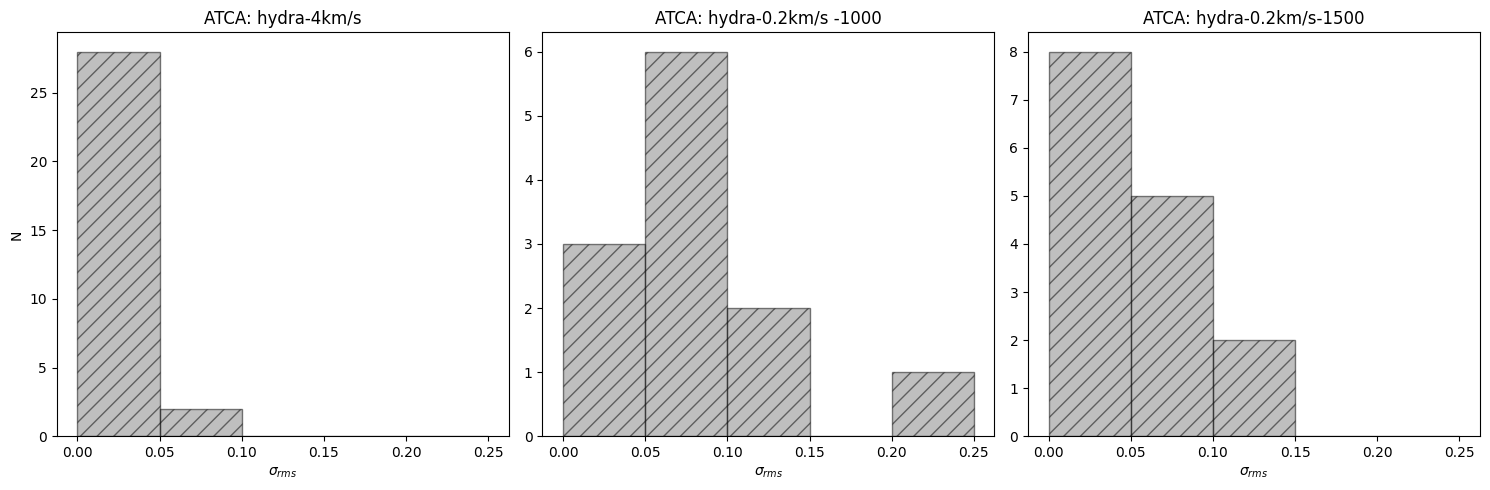

In [9]:
# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Define a common bin array with a fixed bin width
bin_width = 0.05  # Set desired bin width
bin_start = min(min(rms_flatten_4k), min(rms_flatten_v2_1000), min(rms_flatten_v2_1500))  # Start of bins
bin_end = max(max(rms_flatten_4k), max(rms_flatten_v2_1000), max(rms_flatten_v2_1500))  # End of bins
bins_common = np.arange(bin_start, bin_end + bin_width, bin_width)  # Create bins

# Plot the histograms
axes[0].hist(rms_flatten_4k, bins=bins_common, color='grey', edgecolor='black', hatch='//', alpha=0.5)
axes[0].set_xlabel(r'$\sigma_{rms}$')
axes[0].set_ylabel('N')
axes[0].set_title(f'ATCA: {source_name}-4km/s')
# axes[0].grid(True)  # Uncomment this line if you want to add a grid

axes[1].hist(rms_flatten_v2_1000, bins=bins_common, color='grey', edgecolor='black', hatch='//', alpha=0.5)
axes[1].set_xlabel(r'$\sigma_{rms}$')
axes[1].set_title(f'ATCA: {source_name}-0.2km/s -1000')
# axes[1].grid(True)  # Uncomment this line if you want to add a grid

axes[2].hist(rms_flatten_v2_1500, bins=bins_common, color='grey', edgecolor='black', hatch='//', alpha=0.5)
axes[2].set_xlabel(r'$\sigma_{rms}$')
axes[2].set_title(f'ATCA: {source_name}-0.2km/s-1500')
# axes[2].grid(True)  # Uncomment this line if you want to add a grid

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### 4 km/s - 140 channels

In [10]:
np.max(data_4k)

0.48031040466047953

In [11]:
# (channel_width_kms, num_channels, rms_low, rms_high, amp)

spectra_4k, signal_4k = create_synthetic_data(4, 140, 0.05, 0.1, 0.5)   # Hydra

#spectra_4k, signal_4k = create_synthetic_data(4, 140, 0.05, 0.15, 1.3)    #Norma

In [12]:
# 4km/s resoultion
array_140 = np.zeros((len(spectra_4k[0]),40, 20))
signal_140 = np.zeros((len(signal_4k[0]),40, 20))
# Fill the NumPy arrays with data from the lists
for i, data in enumerate(spectra_4k):
    index1 = i // 20  # Row index
    index2 = i % 20   # Column index
    array_140[:, index1, index2] = data
    
for i, data in enumerate(signal_4k):
    index1 = i // 20  # Row index
    index2 = i % 20   # Column index
    signal_140[:, index1, index2] = data

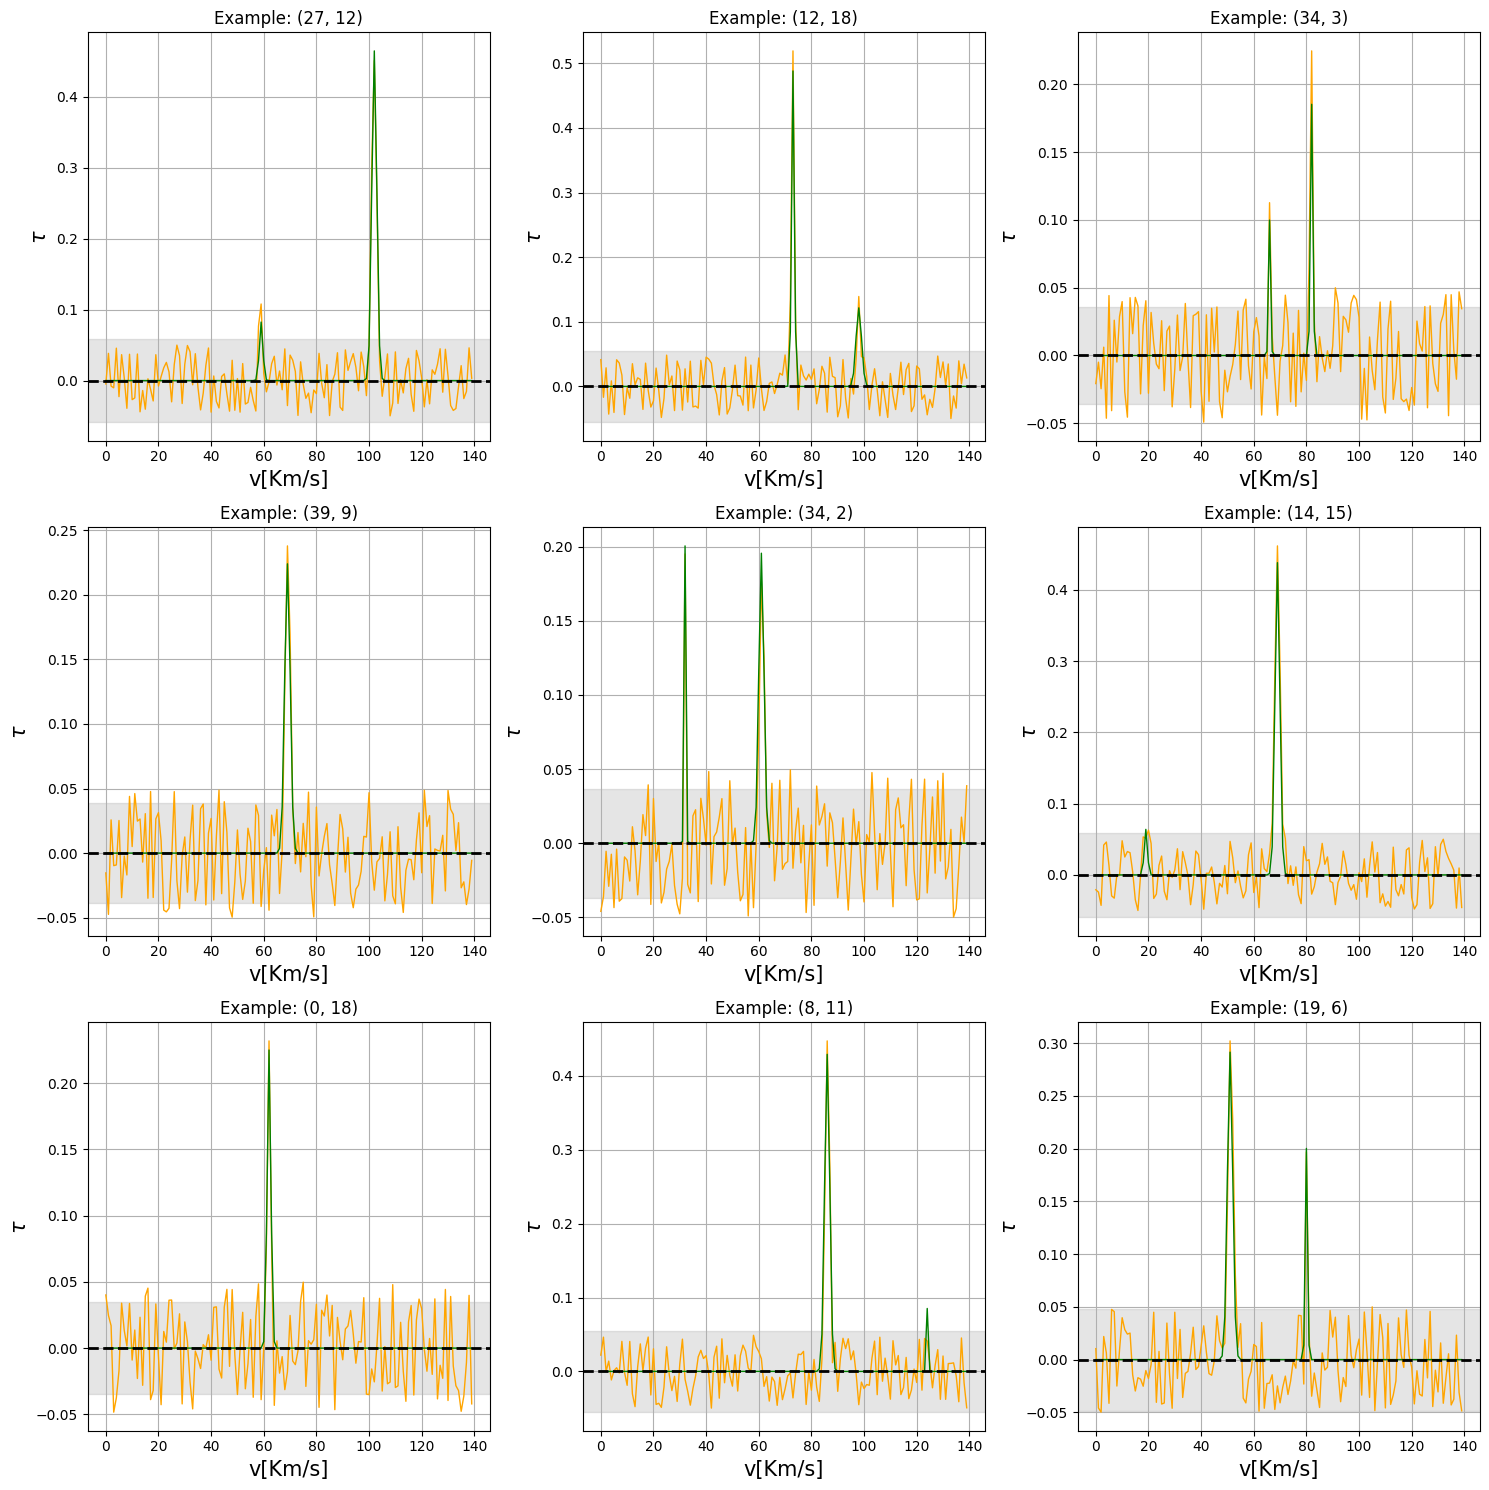

In [13]:
# Example usage
plot_data_examples(array_140,signal_140)#, 'synthetic_4k', source_name)

### 0.2km/s - 1000 channels

In [14]:
np.max(data_v2_1000)

0.8656785771227224

In [15]:
# (channel_width_kms, num_channels, rms_low, rms_high, amp)

spectra_v2_1000, signal_v2_1000 = create_synthetic_data(0.2, 1000, 0.05, 0.15, 0.9) #Hydra
#spectra_v2_1000, signal_v2_1000 = create_synthetic_data(0.2, 1000, 0.45, 0.75, 7)  #Norma

In [16]:
array_1000 = np.zeros((len(spectra_v2_1000[0]),40, 20))
# Fill the NumPy arrays with data from the lists
for i, data_v2_1000 in enumerate(spectra_v2_1000):
    index1 = i // 20  # Row index
    index2 = i % 20 # Column index
    array_1000[:, index1, index2] = data_v2_1000
    
signal_1000 = np.zeros((len(signal_v2_1000[0]),40, 20))
# Fill the NumPy arrays with data from the lists
for i, data_v2_1000 in enumerate(signal_v2_1000):
    index1 = i // 20  # Row index
    index2 = i % 20 # Column index
    signal_1000[:, index1, index2] = data_v2_1000

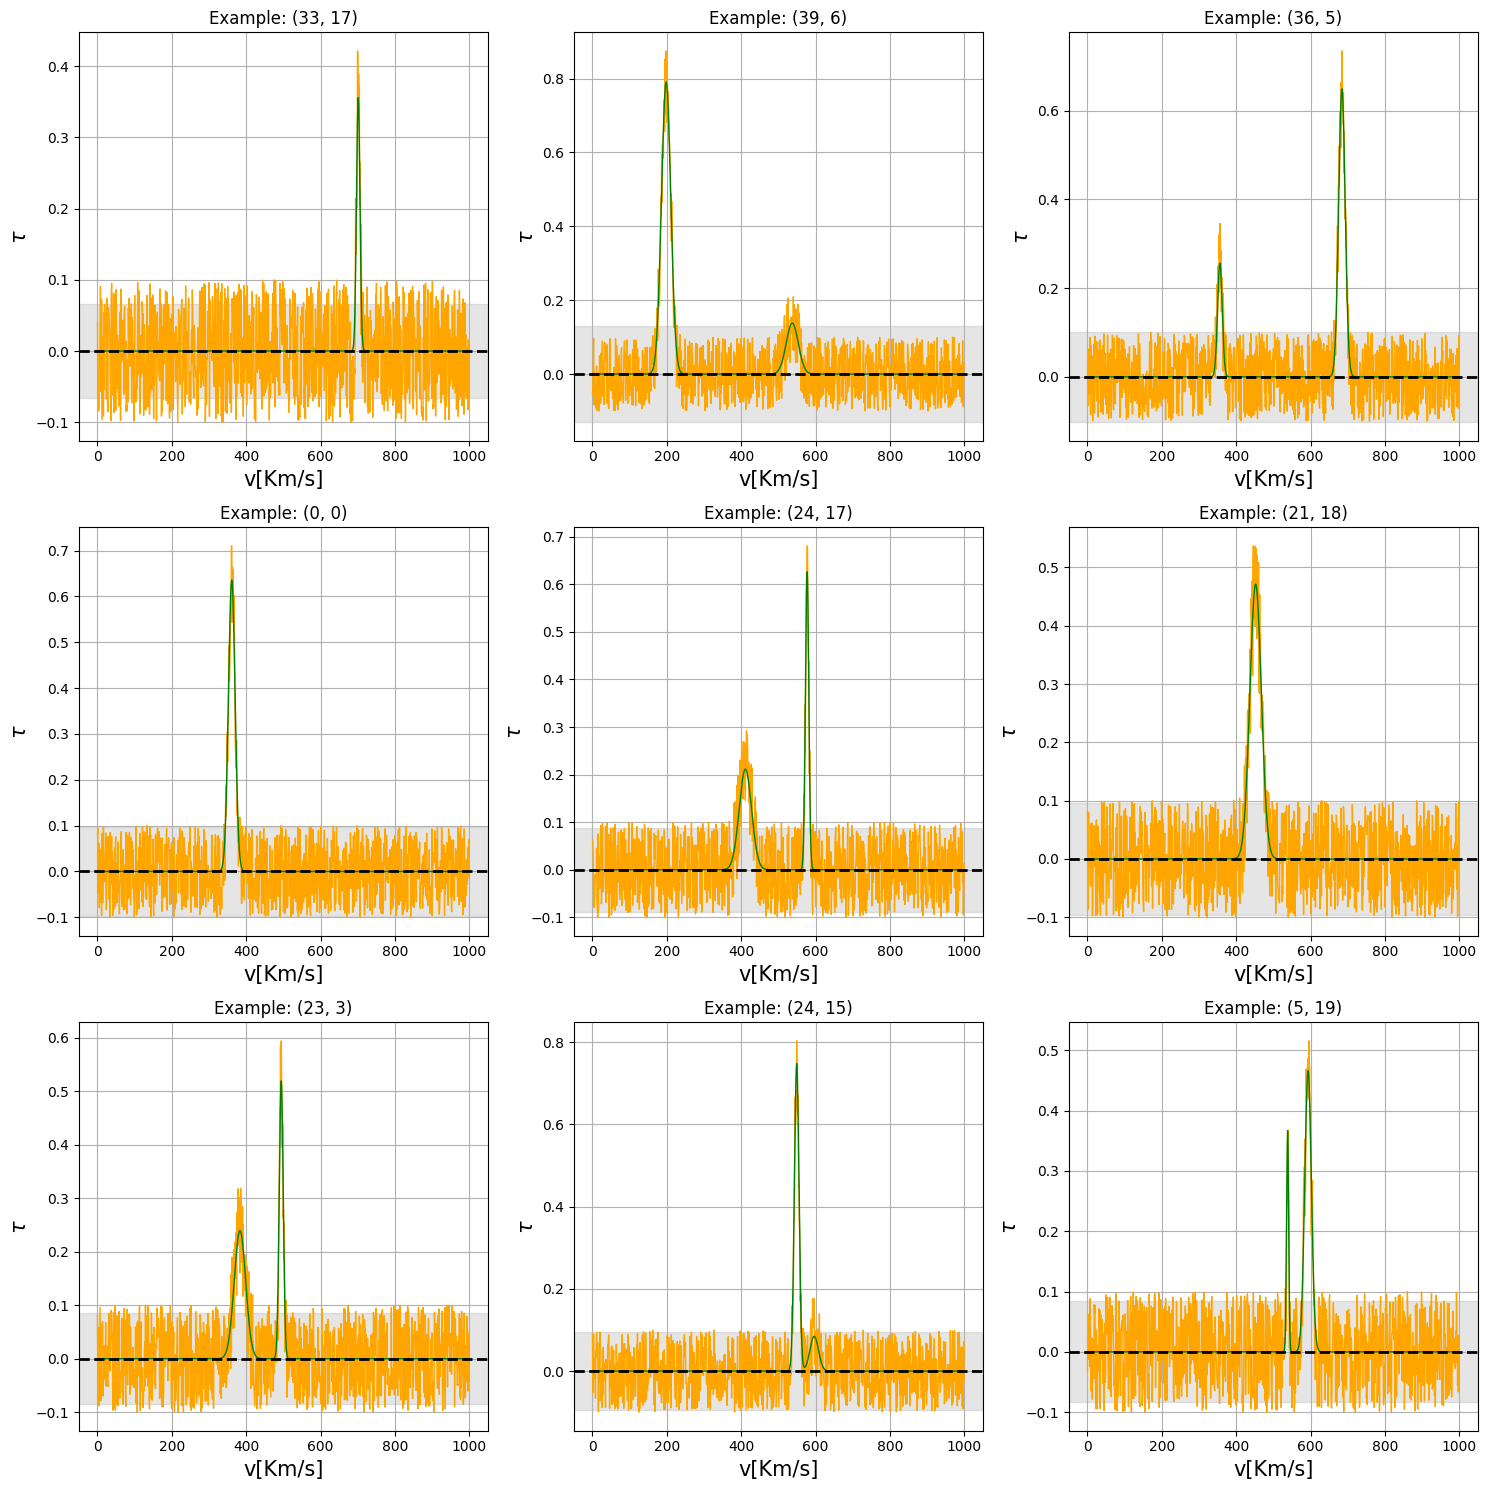

In [17]:
plot_data_examples(array_1000,signal_1000)#, 'synthetic_v2-1000',source_name)

### 0.2km/s - 1500 channels

In [18]:
np.max(data_v2_1500)

0.8870121946311383

In [19]:
spectra_v2_1500, signal_v2_1500 = create_synthetic_data(0.2, 1500, 0.05, 0.15, 0.9) #Hydra
#spectra_v2_1500, signal_v2_1500 = create_synthetic_data(0.2, 1500, 0.05, 0.45, 6) #Norma

In [20]:
array_1500 = np.zeros((len(spectra_v2_1500[0]),40, 20))
# Fill the NumPy arrays with data from the lists
for i, data_v2_1500 in enumerate(spectra_v2_1500):
    index1 = i // 20  # Row index
    index2 = i % 20 # Column index
    array_1500[:, index1, index2] = data_v2_1500   
    
signal_1500 = np.zeros((len(signal_v2_1500[0]),40, 20))
# Fill the NumPy arrays with data from the lists
for i, data_v2_1500 in enumerate(signal_v2_1500):
    index1 = i // 20  # Row index
    index2 = i % 20 # Column index
    signal_1500[:, index1, index2] = data_v2_1500   

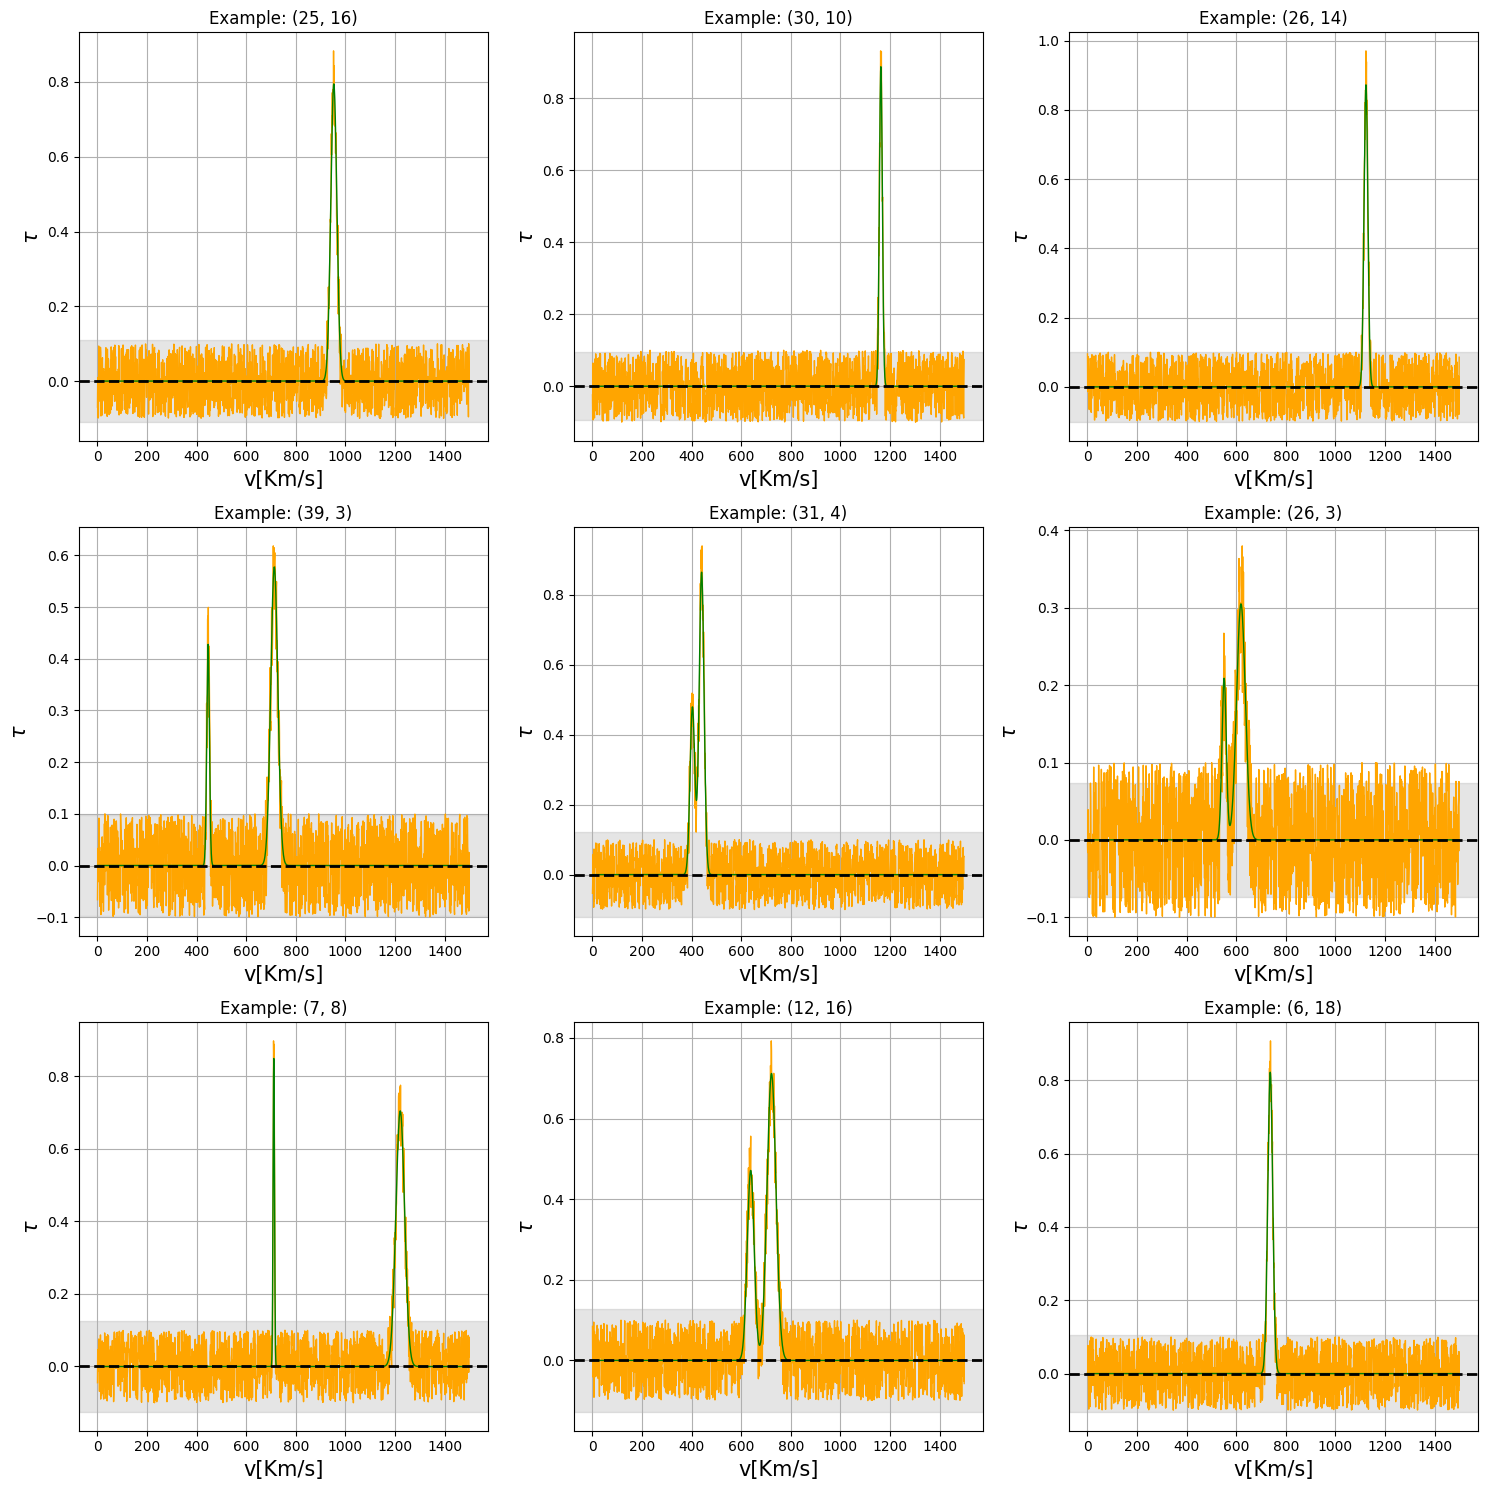

In [21]:
plot_data_examples(array_1500, signal_1500)#,'synthetic_v2-1500', source_name)

### Fits cube 

In [22]:
def fits_cube(data_cube, CDELT3, CRVAL3, name, source):
    # Create a new FITS HDU object from the NumPy 
    hdu = fits.PrimaryHDU(data_cube)

    hdu.header['NAXIS'] = 3
    hdu.header['NAXIS1'] = data_cube.shape[1]
    hdu.header['NAXIS2'] = data_cube.shape[2]
    hdu.header['NAXIS3'] = data_cube.shape[0]


    hdu.header['CRPIX1'] = 1.0e+00
    hdu.header['CDELT1'] = 1.0e+00
    hdu.header['CRVAL1'] = 1.0e+00
    hdu.header['CTYPE1']  = 'RA---NCP'
    hdu.header['CUNIT1'] = 'deg'

    hdu.header['CRPIX2'] = 1.0e+00
    hdu.header['CDELT2'] = 1.0e+00
    hdu.header['CRVAL2'] = 1.0e+00
    hdu.header['CTYPE2']  = 'DEC--NCP'
    hdu.header['CUNIT2'] = 'deg'


    hdu.header['CRPIX3']  = 1.0e+00
    hdu.header['CDELT3'] = CDELT3      #km/s
    hdu.header['CTYPE3']  = 'VELO-LSR'
    hdu.header['CRVAL3'] = CRVAL3      #km/s
    hdu.header['CUNIT3'] = 'km/s' 
    
    hdu.header['DATAMIN'] =  np.nanmin(data_cube)                        
    hdu.header['DATAMAX'] =  np.nanmax(data_cube)   
    
    hdu.header['SPECSYS'] = 'LSRK' 
    hdu.header['BUNIT'] = 'JY/BEAM '                                                                                                                                                                                                                                                                                                          


    # Save the FITS file
    hdu.writeto(f'Data_cubes/{source}/{name}.fits', overwrite=True)


In [23]:
fits_cube(array_140, 3.91596771184 , -192.245054387, 'synthetic_4k', source_name)

In [24]:
fits_cube(array_1500, 0.206106359695 , -138.952968077, 'synthetic_v2-1500',source_name)

In [25]:
fits_cube(array_1000, 0.206106359695 , -111.5981058, 'synthetic_v2-1000',source_name)

## Checking

In [26]:
from spectral_cube import SpectralCube

# Path to the FITS file
file_path = f'Data_cubes/{source_name}/synthetic_v2-1500.fits'
#file_path = 'j100634-2914_cube_v2.fits'

cube = SpectralCube.read(file_path)
# Open the FITS file
with fits.open(file_path) as hdul:
    # Print the information about the FITS file
    hdul.info()
    
    # Access the primary HDU (Header/Data Unit)
    primary_hdu = hdul[0]
    
    # Print the header of the primary HDU
    print(primary_hdu.header)
    
    # Access the data in the primary HDU
    data = primary_hdu.data

# Display some basic information about the data
print(f'Data shape: {data.shape}')
print(f'Data type: {data.dtype}')


Filename: Data_cubes/hydra/synthetic_v2-1500.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   (20, 40, 1500)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                   20                                                  NAXIS2  =                   40                                                  NAXIS3  =                 1500                                                  EXTEND  =                    T                                                  CRPIX1  =                  1.0                                                  CDELT1  =                  1.0                                                  CRVAL1  =                  1.0                                                  CTYPE1  = 'RA---NC

In [27]:
cube.spectral_axis

<Quantity [-138.95296808, -138.74686172, -138.54075536, ...,  169.58825239,
            169.79435875,  170.00046511] km / s>

In [28]:
data

array([[[ 0.09513746,  0.09188582, -0.03070557, ...,  0.07422038,
          0.02316431, -0.08251434],
        [-0.09113929, -0.05416518, -0.01668903, ...,  0.05575196,
         -0.04916339, -0.08318543],
        [-0.00766516,  0.08133135,  0.08294414, ...,  0.09964076,
          0.04488804,  0.03619516],
        ...,
        [ 0.04536124, -0.06291544,  0.00297718, ...,  0.03202648,
         -0.02023932,  0.08761038],
        [-0.05564172,  0.0243067 , -0.00913285, ...,  0.01724863,
         -0.07979383, -0.03734145],
        [-0.00780933,  0.08532289,  0.01971521, ...,  0.0399137 ,
         -0.03250286,  0.05890545]],

       [[ 0.07591854, -0.09805113,  0.09678542, ..., -0.03420343,
         -0.09658346, -0.07896796],
        [ 0.0185925 , -0.02916786, -0.06293457, ..., -0.06822775,
         -0.04513913, -0.0527218 ],
        [-0.03388139, -0.07855516,  0.06841758, ..., -0.065799  ,
          0.0759613 , -0.06632007],
        ...,
        [ 0.02839271,  0.05145755, -0.01767778, ..., -